## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install it:

In [1]:
!pip3 install git+https://github.com/thilowrona/fatbox.git

  Cloning https://github.com/thilowrona/fatbox.git to /tmp/pip-req-build-gzcudg9p
  Running command git clone -q https://github.com/thilowrona/fatbox.git /tmp/pip-req-build-gzcudg9p
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-install-vihfwcpj/cv-algorithms_59ae030ef6f543c9873665f6a2f31418
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-install-vihfwcpj/cv-algorithms_59ae030ef6f543c9873665f6a2f31418
     |████████████████████████████████| 167 kB 3.0 MB/s 
     |████████████████████████████████| 88.3 MB 68 kB/s 
     |████████████████████████████████| 232 kB 30.5 MB/s 
     |████████████████████████████████| 51 kB 4.5 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 144 kB 54.0 MB/s 
     |████████████████████████████████| 271 kB 54.3 MB/s 
  Created wheel for fatbox: filename=fatbox-0.0.1-py3-none-any.whl size=29

In [2]:
!pip install googledrivedownloader

download the tutorials:

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1RNF_XrfhNwWyBv7MRRDPL1NI0OY2VXbv',
                                    dest_path='./dem_crop2.npy',
                                    unzip=False)

Now we can load the python packages that we need:

In [4]:
!pip install earthpy

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 1.0 MB 41.6 MB/s 
     |████████████████████████████████| 19.3 MB 72.6 MB/s 
     |████████████████████████████████| 6.3 MB 27.1 MB/s 
     |████████████████████████████████| 16.7 MB 18.8 MB/s 


In [5]:
import numpy as np 
import networkx as nx
import pickle
import cv2

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from skimage import feature, morphology, filters
from sklearn.preprocessing import normalize

from sys import stdout

import earthpy.spatial as es
import earthpy.plot as ep

from fatbox.preprocessing import *
from fatbox.metrics import *
from fatbox.edits import *
from fatbox.plots import *

In [6]:
from matplotlib.colors import LinearSegmentedColormap

for map in plt.colormaps():
  # get colormap
  ncolors = 256
  color_array = plt.get_cmap(map)(range(ncolors))

  # change alpha values
  color_array[:,-1] = np.linspace(0.0,0.5,ncolors)

  # create a colormap object
  map_object = LinearSegmentedColormap.from_list(name= map + '_alpha',colors=color_array)

  # register this new colormap with matplotlib
  plt.register_cmap(cmap=map_object)

## Fault extraction

First, we load our data:

In [7]:
DEM = np.load('/content/dem_crop2.npy')

Now we can plot the DEM with hillshade:

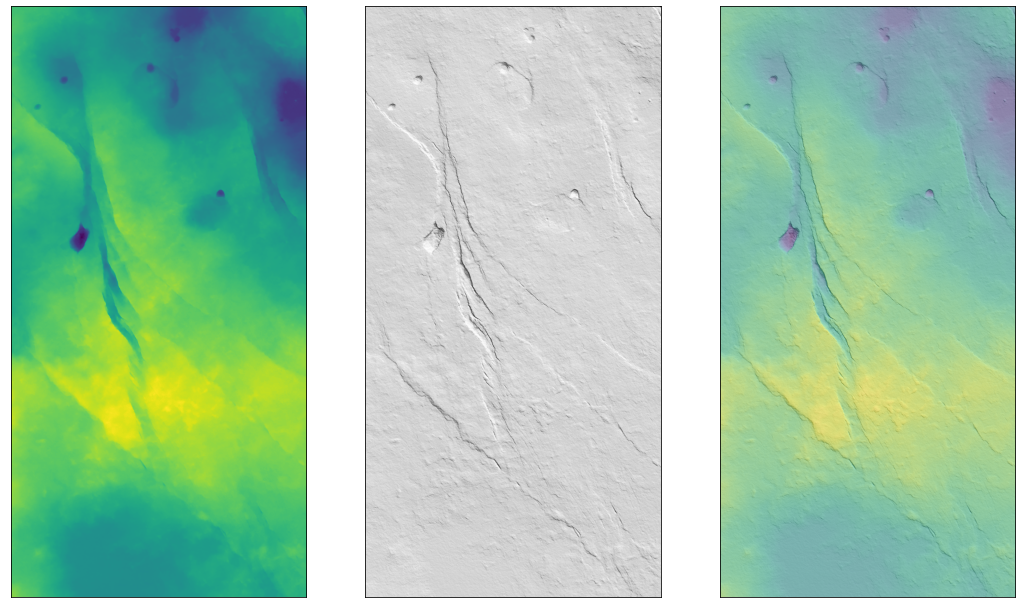

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18,12))

im0 = axs[0].imshow(DEM)
axs[0].set_xticks([])
axs[0].set_yticks([])

ep.plot_bands(es.hillshade(DEM), cbar=False, ax=axs[1])

ep.plot_bands(es.hillshade(DEM), cbar=False, ax=axs[2])
axs[2].imshow(DEM, alpha=0.5)

plt.show()

Now we can calculate the slope:

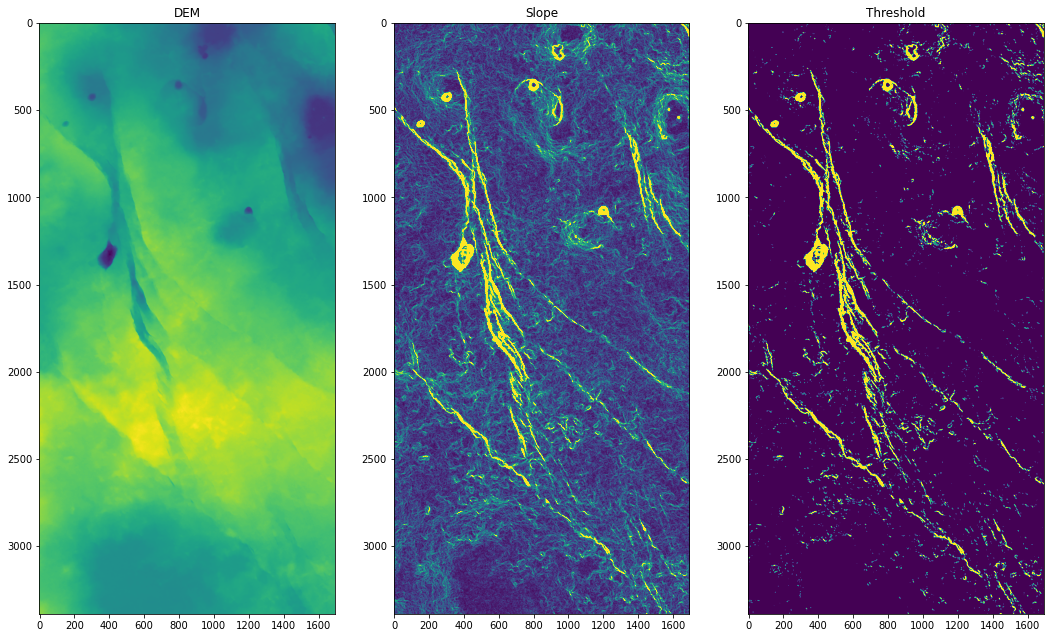

In [9]:
slope = np.gradient(DEM)

dx = slope[0]
dy = slope[1]

dx_abs = abs(dx)
dy_abs = abs(dy)

slope_abs = dx_abs+dy_abs

threshold = simple_threshold_binary(slope_abs, 0.4)


fig, axs = plt.subplots(1, 3, figsize=(18,12))
axs[0].imshow(DEM)
axs[0].set_title('DEM')
axs[1].imshow(slope_abs, vmax=0.5)
axs[1].set_title('Slope')
axs[2].imshow(threshold, vmax=0.5)
axs[2].set_title('Threshold')
plt.show()

and we calculate the edges, too:

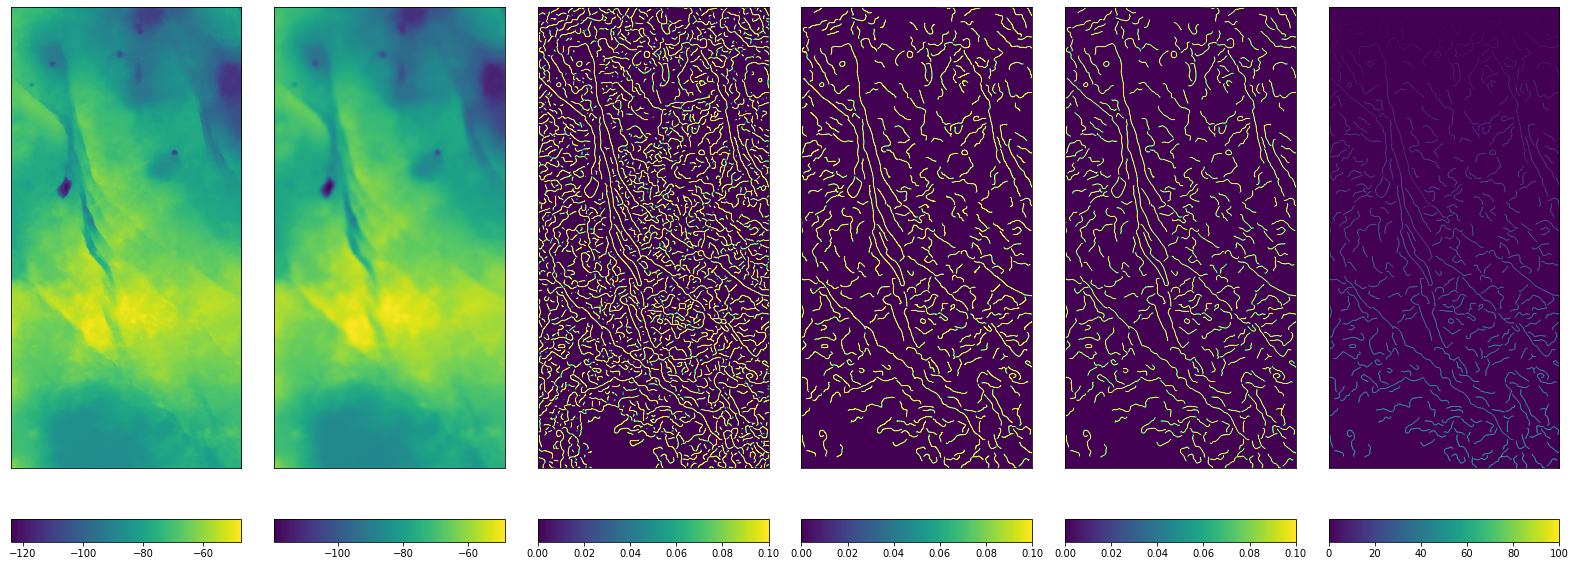

In [14]:
smoothed = filters.gaussian(DEM, sigma=10)
edges = feature.canny(smoothed)
cleaned = morphology.remove_small_objects(edges, connectivity=2, min_size=100).astype('uint8')
skeleton = skeleton_guo_hall(cleaned)
ret, markers = cv2.connectedComponents(skeleton)

fig, axs = plt.subplots(1, 6, figsize=(22,10))
im0 = axs[0].imshow(DEM)
axs[0].set_xticks([])
axs[0].set_yticks([])
divider = make_axes_locatable(axs[0])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im0, cax=cax, orientation="horizontal")


im1 = axs[1].imshow(smoothed)
axs[1].set_xticks([])
axs[1].set_yticks([])
divider = make_axes_locatable(axs[1])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im1, cax=cax, orientation="horizontal")


im2 = axs[2].imshow(edges, vmin=0, vmax=0.1)
axs[2].set_xticks([])
axs[2].set_yticks([])
divider = make_axes_locatable(axs[2])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im2, cax=cax, orientation="horizontal")


im3 = axs[3].imshow(cleaned, vmin=0, vmax=0.1)
axs[3].set_xticks([])
axs[3].set_yticks([])
divider = make_axes_locatable(axs[3])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im3, cax=cax, orientation="horizontal")

im4 = axs[4].imshow(skeleton, vmin=0, vmax=0.1)
axs[4].set_xticks([])
axs[4].set_yticks([])
divider = make_axes_locatable(axs[4])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im4, cax=cax, orientation="horizontal")

im5 = axs[5].imshow(markers, vmax=100)
axs[5].set_xticks([])
axs[5].set_yticks([])
divider = make_axes_locatable(axs[5])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im5, cax=cax, orientation="horizontal")


plt.tight_layout()
plt.show()

These components become the nodes of our graph G:

In [20]:
G = nx.Graph()

node = 0
for comp in range(1,ret):

    points = np.transpose(np.vstack((np.where(markers==comp))))    
    
    for point in points:
        G.add_node(node)
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['component'] = comp
        node += 1    

And we connect them within each component (this takes a minute):

In [21]:
for comp in range(1,ret): 
    
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    dm = distance_matrix(points, points)  
    
    
    for n in range(len(points)):
        # print(n)
        for m in range(len(points)):
            if dm[n,m]<1.5 and n != m:
                G.add_edge(nodes[n],nodes[m])

Now we can label the graph and look at our result:

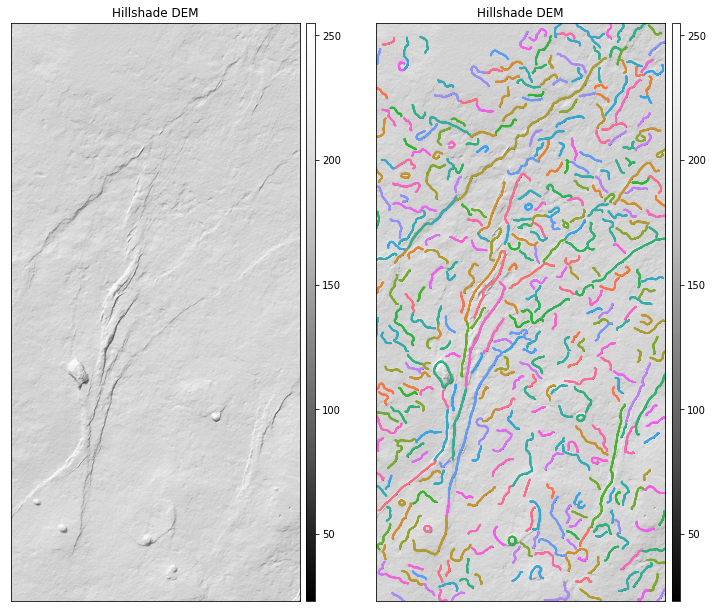

In [22]:
G = label_components(G)

# Plot arrays
fig, axs = plt.subplots(1, 2, figsize=(12,12), sharey=True)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=True, title="Hillshade DEM", figsize=(10, 6), ax=axs[0],
)
ep.plot_bands(
    hillshade, cbar=True, title="Hillshade DEM", figsize=(10, 6), ax=axs[1],
)
plot_components(G, ax=axs[1], node_size=0.75, label=False)

axs[1].set_xlim([0, DEM.shape[1]])
axs[1].set_ylim([0, DEM.shape[0]])

plt.show()

Okay there are still quite a few artefacts in the network, but they can be removed using the interactive masking tool. This interactivity is unfortunately not supported by Jupyter notebooks, but we can compare the two versions of the network:

In [18]:
!git clone https://github.com/thilowrona/fatbox_tutorials

Cloning into 'fatbox_tutorials'...
remote: Enumerating objects: 410, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 410 (delta 86), reused 181 (delta 61), pack-reused 171
Receiving objects: 100% (410/410), 41.81 MiB | 23.22 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [23]:
G_clean = pickle.load(open('./fatbox_tutorials/Digital_elevation_models/G_clean.p', 'rb'))

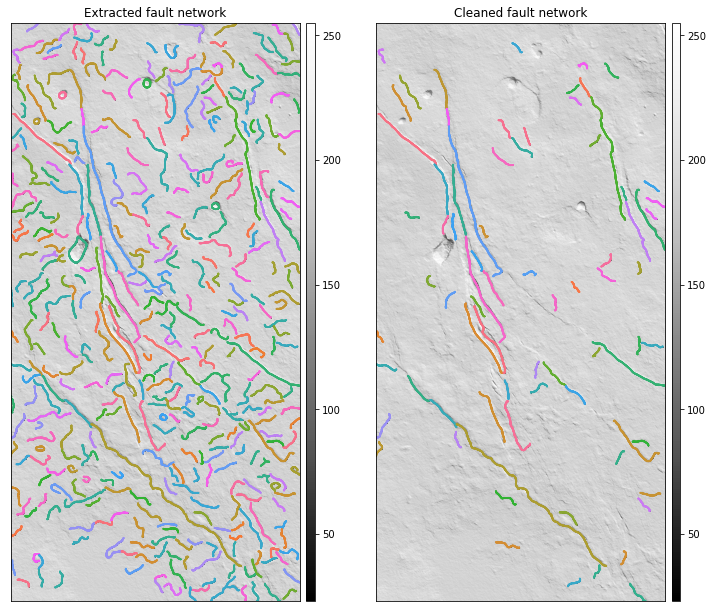

In [26]:
# Plot arrays
fig, axs = plt.subplots(1, 2, figsize=(12,12), sharey=True)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=True, title="Extracted fault network", figsize=(10, 6), ax=axs[0],
)
plot_components(G, ax=axs[0], node_size=0.75, label=False)

axs[0].set_xlim([0, DEM.shape[1]])
axs[0].set_ylim([DEM.shape[0], 0])


ep.plot_bands(
    hillshade, cbar=True, title="Cleaned fault network", figsize=(10, 6), ax=axs[1],
)
plot_components(G_clean, ax=axs[1], node_size=0.75, label=False)

axs[1].set_xlim([0, DEM.shape[1]])
axs[1].set_ylim([DEM.shape[0], 0])

plt.show()

Next we want to calculate the vertical fault displacment (or throw) from the DEM. To do this, we first need the direction of the faults:

In [41]:
def calculate_direction(G, cutoff, normalize=True):
    """ Calculate direction for entire network
    
    Parameters
    ----------
    G : nx.graph
        Fault network
    cutoff : int, float
        Cutoff distance for direction
    normalize : bolean
        Normalize direction (default: True)
    
    Returns
    -------  
    G
        nx.graph
    """   
    
    # Assertions
    assert isinstance(G, nx.Graph), 'G is not a NetworkX graph'

    # Calculation
    for node in G.nodes:

        length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff)
        keys = [keys for keys, values in length.items() if values == max(length.values())]

        if len(keys) > 2:
            (node_0, node_1) = keys[:2]

        if len(keys) == 2:
            (node_0, node_1) = keys
        if len(keys) == 1:
            node_0 = keys[0]

            length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff - 1)
            keys = [keys for keys, values in length.items() if values == max(length.values())]

            node_1 = keys[0]

        # here the directions are made consistently for N-S trending faults
        if G.nodes[node_0]['pos'][1] < G.nodes[node_1]['pos'][1]:
          pt_0 = G.nodes[node_0]['pos']
          pt_1 = G.nodes[node_1]['pos']
        else:
          pt_0 = G.nodes[node_1]['pos']
          pt_1 = G.nodes[node_0]['pos']         

        # calculate vector
        dx = pt_0[0] - pt_1[0]
        dy = pt_0[1] - pt_1[1]
        
        # write to graph
        G.nodes[node]['dx'] = dx
        G.nodes[node]['dy'] = dy

    return G

G_clean = calculate_direction(G_clean, cutoff=3)

Now we can generate pick-up points, where we will extract the surface elevation to determine hanging and footwall of the faults.

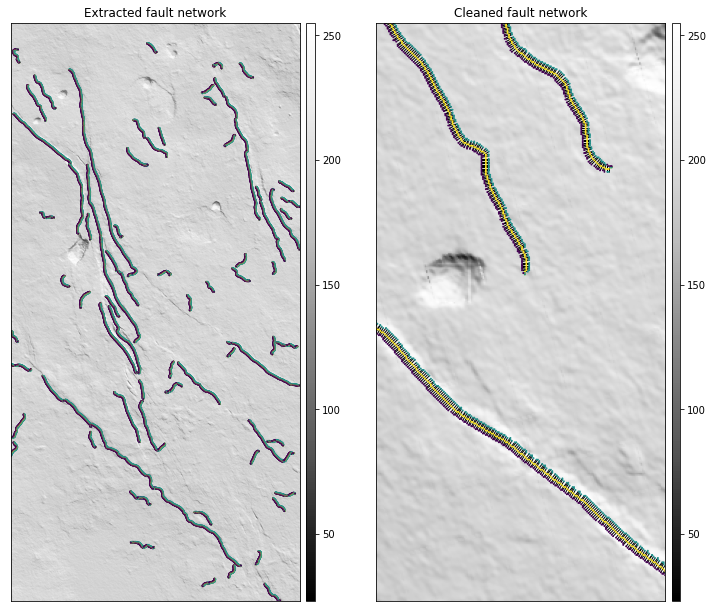

In [60]:
P_up = generate_pickup_points(G_clean, factor=0.4)

# Plot arrays
fig, axs = plt.subplots(1, 2, figsize=(12,12), sharey=False)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=True, title="Extracted fault network", figsize=(10, 6), ax=axs[0],
)
plot_attribute(P_up, 'component', colorbar=False, ax=axs[0])

axs[0].set_xlim([0, DEM.shape[1]])
axs[0].set_ylim([DEM.shape[0], 0])


ep.plot_bands(
    hillshade, cbar=True, title="Cleaned fault network", figsize=(10, 6), ax=axs[1],
)
plot_attribute(P_up, 'component', colorbar=False, ax=axs[1])

axs[1].set_xlim([100, 300])
axs[1].set_ylim([800, 400])

plt.show()

Now we extract the elevation from the pick-up points and write the difference back to the fault network:

In [44]:
P_up = extract_attribute(P_up, DEM, 'elevation')
for node in G_clean:
  G_clean.nodes[node]['difference'] = P_up.nodes[(node,1)]['elevation'] - P_up.nodes[(node,2)]['elevation']

Note that this is not the throw, it's just the elevation difference between either side of the fault:

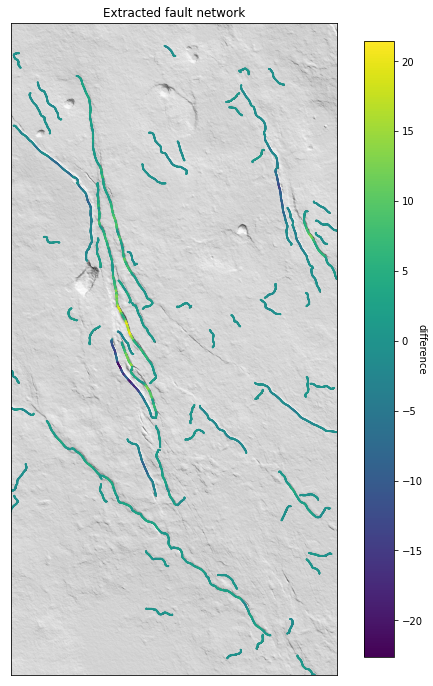

In [48]:
# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(12,12), sharey=False)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=False, title="Extracted fault network", figsize=(10, 6), ax=ax,
)
plot_attribute(G_clean, 'difference', colorbar=True, ax=ax)

ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([DEM.shape[0], 0])

plt.show()

Now we can use this difference to determine the dip direction for the throw calculation. First we calculate the mean difference for each fault, i.e. component:

In [49]:
for comp in nx.connected_components(G_clean):
  value = np.mean([G_clean.nodes[node]['difference'] for node in comp])
  for node in comp:
    G_clean.nodes[node]['mean_difference'] = value

Then the dip direction:

In [50]:
threshold = 0.1
for comp in nx.connected_components(G_clean):
  value = np.mean([G_clean.nodes[node]['difference'] for node in comp])
  if value > threshold:
    for node in comp:
      G_clean.nodes[node]['dip_dir_auto'] = -1
  elif value < -threshold:
    for node in comp:
      G_clean.nodes[node]['dip_dir_auto'] = 1
  else:
    for node in comp:
      G_clean.nodes[node]['dip_dir_auto'] = 0

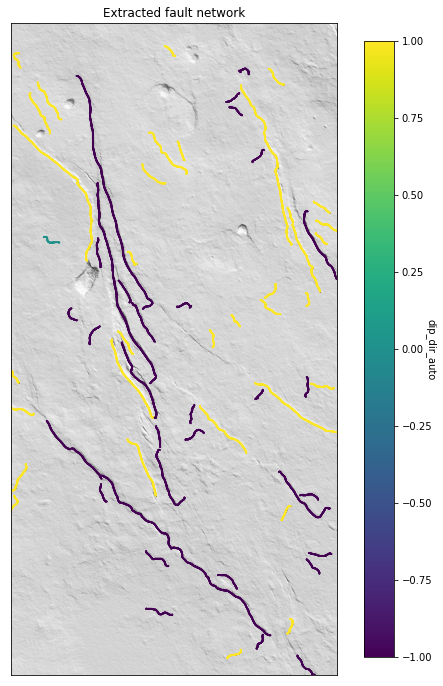

In [51]:
# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(12,12), sharey=False)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=False, title="Extracted fault network", figsize=(10, 6), ax=ax,
)
plot_attribute(G_clean, 'dip_dir_auto', colorbar=True, ax=ax)

ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([DEM.shape[0], 0])

plt.show()

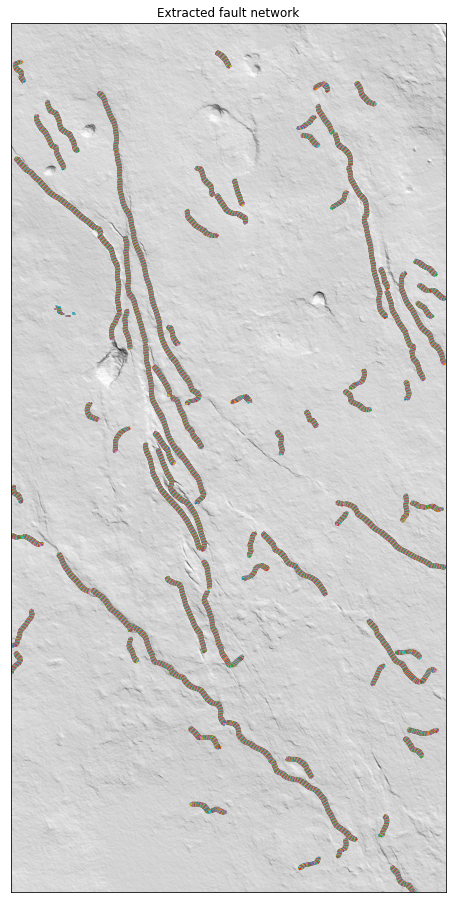

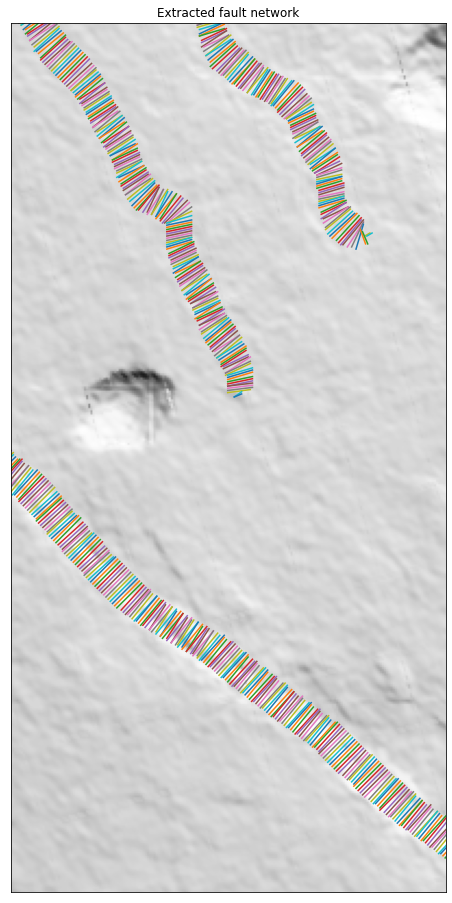

In [64]:
def get_throws(G, DEM, factor, dip_dir_auto=[], plot_profiles=False):
       
    '''G = Graph 
    DEM = Digital elevation model as numpy array
    factor = across-fault profile lenght
    dip_dir = fault dip direction. It consider just E- and W-dipping faults. 
    Alternatively you can avoid to specify this option '''
    
    # Assertions
    assert isinstance(DEM, np.ndarray), 'DEM is not a NumPy array' 
    for node in G:

        (x, y) = G.nodes[node]['pos']

        dx = G.nodes[node]['dx']
        dy = G.nodes[node]['dy']

        dx = factor * dx
        dy = factor * dy

        x_p = int(x - dy)
        y_p = int(y + dx)

        x_n = int(x + dy)
        y_n = int(y - dx)

        if x_p < 0:
            x_p = 0

        if x_p >= DEM.shape[1]:
            x_p = DEM.shape[1]-1
  
        if y_p < 0:
            y_p = 0

        if y_p >= DEM.shape[0]:
            y_p = DEM.shape[0]-1

        if x_n < 0:
            x_n = 0

        if x_n >= DEM.shape[1]:
            x_n = DEM.shape[1]-1
  
        if y_n < 0:
            y_n = 0

        if y_n >= DEM.shape[0]:
            y_n = DEM.shape[0]-1


        n = 100
        
        '''dx and dy vary in sign and this can cause a wrong profile extraction. 
        The following lines take this into account to extract always the right 
        profile on the basis of the fault dip direction and dx, dy positions.'''
        
        '''This is for W-dipping faults. It extracts asymmetric profiles'''
        if G.nodes[node]['dip_dir_auto'] == -1: 
                xl, yl = np.linspace(x_p-factor, x_n-(factor*4), n), np.linspace(y_p+factor, y_n+(factor*4), n)
            
        '''this is for E-dipping faults. It extracts asymmetric profiles'''  
        if G.nodes[node]['dip_dir_auto'] == 1:   
                xl, yl = np.linspace(x_p+(factor*4), x_n+factor, n), np.linspace(y_p-(factor*4), y_n-factor, n)
                
        '''this is for no dip fault. It extracts symmetric profiles'''        
        if G.nodes[node]['dip_dir_auto'] == 0: 
                xl, yl = np.linspace(x_p, x_n, n), np.linspace(y_p, y_p, n)

        if plot_profiles:
          plt.plot(xl, yl)

        # Extract the values along the line
        values = np.zeros(n)

        for n, (x, y) in enumerate(zip(xl,yl)):
            if x < 0 or x >= DEM.shape[1]:
              values[n] = float('nan')
            elif y < 0 or y >= DEM.shape[0]:
              values[n] = float('nan')
            else:
              values[n] = DEM[int(y),int(x)]

        # Compute minimum/maximum
        minimum = np.nanpercentile(values, 5)
        maximum = np.nanpercentile(values, 95)

        # Write throw to graph
        G.nodes[node]['throw'] = maximum - minimum

    return G


# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(16,16), sharey=False)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=False, title="Extracted fault network", figsize=(10, 6), ax=ax,
)
G_clean = get_throws(G_clean, DEM, 0.8, plot_profiles=True)

ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([DEM.shape[0], 0])

plt.show()



# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(16,16), sharey=False)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=False, title="Extracted fault network", figsize=(10, 6), ax=ax,
)
G_clean = get_throws(G_clean, DEM, 0.8, plot_profiles=True)

ax.set_xlim([100, 300])
ax.set_ylim([800, 400])

plt.show()


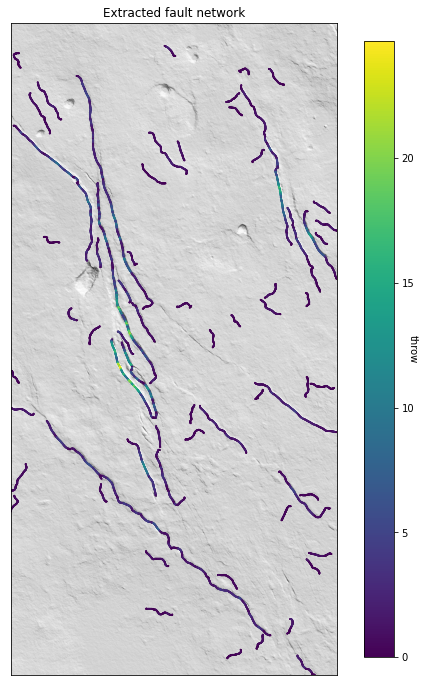

In [56]:
# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(12,12), sharey=False)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=False, title="Extracted fault network", figsize=(10, 6), ax=ax,
)
plot_attribute(G_clean, 'throw', colorbar=True, ax=ax)

ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([DEM.shape[0], 0])

plt.show()